<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Grokking_as_the_Transition_from_Lazy_to_Rich_Training_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ※ 原論文の実験の詳細（ハイパーパラメータ）が不明

* $\boldsymbol{x} \in \mathbb{R}^D $
* $\boldsymbol{x} \sim \mathcal{N}(0, \frac{1}{D}\boldsymbol{I}) $

\\

* $ \{ (\boldsymbol{x}_\mu, \; y_\mu) \}_{\mu = 1}^P $：データセット

**モデル：**


$f(\boldsymbol{w}, \boldsymbol{x}) = \frac{\alpha}{N} \sum_{i=1}^N \phi(\boldsymbol{w}_i \cdot \boldsymbol{x})$

* $\phi(h) = h + \frac{\epsilon}{2}h^2$

\\

**ターゲット：**

* $ y(\boldsymbol{x}) = \frac{1}{2}(\boldsymbol{\beta}_{\star} \cdot \boldsymbol{x})^2 $

Epoch [100/30000], Train Loss: 0.0056, Test Loss: 0.0054
Epoch [200/30000], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [300/30000], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [400/30000], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [500/30000], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [600/30000], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [700/30000], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [800/30000], Train Loss: 0.0048, Test Loss: 0.0047
Epoch [900/30000], Train Loss: 0.0048, Test Loss: 0.0047
Epoch [1000/30000], Train Loss: 0.0048, Test Loss: 0.0046
Epoch [1100/30000], Train Loss: 0.0047, Test Loss: 0.0046
Epoch [1200/30000], Train Loss: 0.0047, Test Loss: 0.0046
Epoch [1300/30000], Train Loss: 0.0046, Test Loss: 0.0045
Epoch [1400/30000], Train Loss: 0.0046, Test Loss: 0.0045
Epoch [1500/30000], Train Loss: 0.0045, Test Loss: 0.0044
Epoch [1600/30000], Train Loss: 0.0044, Test Loss: 0.0044
Epoch [1700/30000], Train Loss: 0.0043, Test Loss: 0.0043
Epoch [1800/30000], Tra

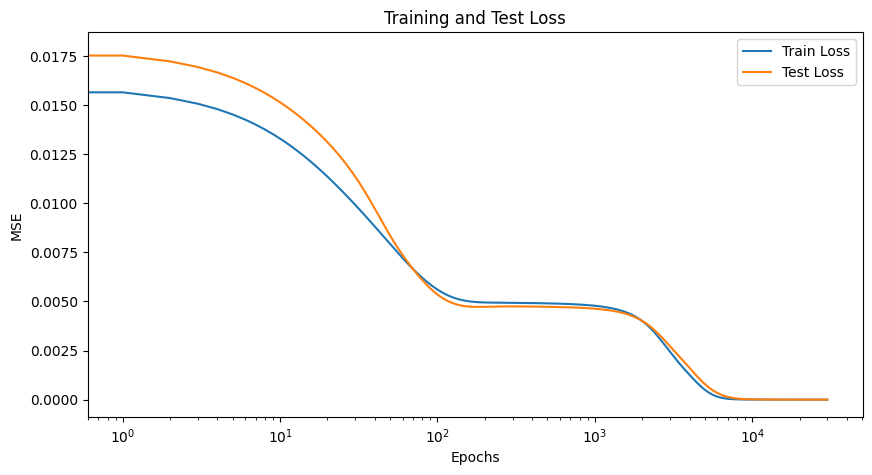

In [250]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# パラメータの設定
D = 10       # 入力次元数
N = 100      # 隠れユニットの数
P_train = 100  # 訓練データセットのサイズ
P_test = 100   # テストデータセットのサイズ
epsilon = 2 ** (-3)  # 初期 NTK アラインメントを制御するパラメータ
alpha = 2 ** 4  # 出力スケール/遅延性を制御するパラメータ
eta_0 = 0.1    # 学習率
epochs = 30000  # 訓練エポック数
optimizer_type = 'Adam'  # 'SGD', 'Adam', 'AdamW', or 'GD (vanilla)'

# データセットの生成
X_train = torch.normal(0, 1/D, size=(P_train, D))
beta_star = torch.randn(D)
y_train = 0.5 * (X_train @ beta_star).pow(2)

X_test = torch.normal(0, 1/D, size=(P_test, D))
y_test = 0.5 * (X_test @ beta_star).pow(2)

# ニューラルネットワークの定義
class TwoLayerMLP(nn.Module):
    def __init__(self, D, N, epsilon, alpha):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(D, N, bias=False)
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, x):
        h = self.fc1(x)
        return (self.alpha / N) * (h + (self.epsilon / 2) * h**2).sum(dim=1)

# モデル，損失関数の初期化
model = TwoLayerMLP(D, N, epsilon, alpha)
criterion = nn.MSELoss()

# オプティマイザの選択
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=eta_0 / alpha**2)
elif optimizer_type == 'GD':
    optimizer = None
else:
    raise ValueError("Unsupported optimizer type")

# 訓練
train_losses = []
test_losses = []
for epoch in range(epochs):

    model.train()

    if optimizer_type == 'GD':
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                # eta_0 = eta_0 / alpha**2
                param -= (eta_0) * param.grad
        model.zero_grad()
    else:
        # 他のオプティマイザの場合
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    # テスト
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# プロット
plt.figure(figsize=(10, 5))
plt.semilogx(train_losses, label='Train Loss')
plt.semilogx(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Test Loss')
plt.legend()
plt.show()